### This notebook performs exploratory analysis on a sewer inspection video by extracting frames and computing visual quality metrics such as motion energy, brightness and sharpness. In the second part, it prepares sampled frames for 3D reconstruction using SIFT feature detection and keypoint matching (not very successful).

#### Google Drive Mount

In [ ]:
from google.colab import drive

import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive is already mounted!")

Drive is already mounted!


In [ ]:
! ls /content/drive/MyDrive/3D_reconstruction

eda_results


In [ ]:
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from base64 import b64encode
from IPython.display import HTML
from datetime import timedelta
from tqdm import tqdm
# import pytesseract
import easyocr  # like tesseract, but uses GPU
from google.colab.patches import cv2_imshow

In [ ]:
import torch
import torch.nn.functional as F

#### EDA

In [ ]:
video_path = '/content/drive/MyDrive/3D_reconstruction/200S0264.mp4'

In [ ]:
output_folder = '/content/200S0264_frames/'
os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
half_frame = frame_count // 2  # halfway point

print(f"Total frames: {frame_count}, starting from frame {half_frame}")

cap.set(cv2.CAP_PROP_POS_FRAMES, half_frame)

frame_num = half_frame
saved_frame_num = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_filename = os.path.join(output_folder, f'frame_{frame_num:05d}.jpg')
    cv2.imwrite(frame_filename, frame)

    frame_num += 1
    saved_frame_num += 1

cap.release()

print(f"Saved {saved_frame_num} frames starting from halfway into {output_folder}")

Total frames: 49242, starting from frame 24621


KeyboardInterrupt: 

In [ ]:
!mv /content/200S0264_frames /content/drive/MyDrive/200S0264_frames


Frames: 49242, FPS: 25.00, Duration: 1969.92 sec
Processed 49241 frames.


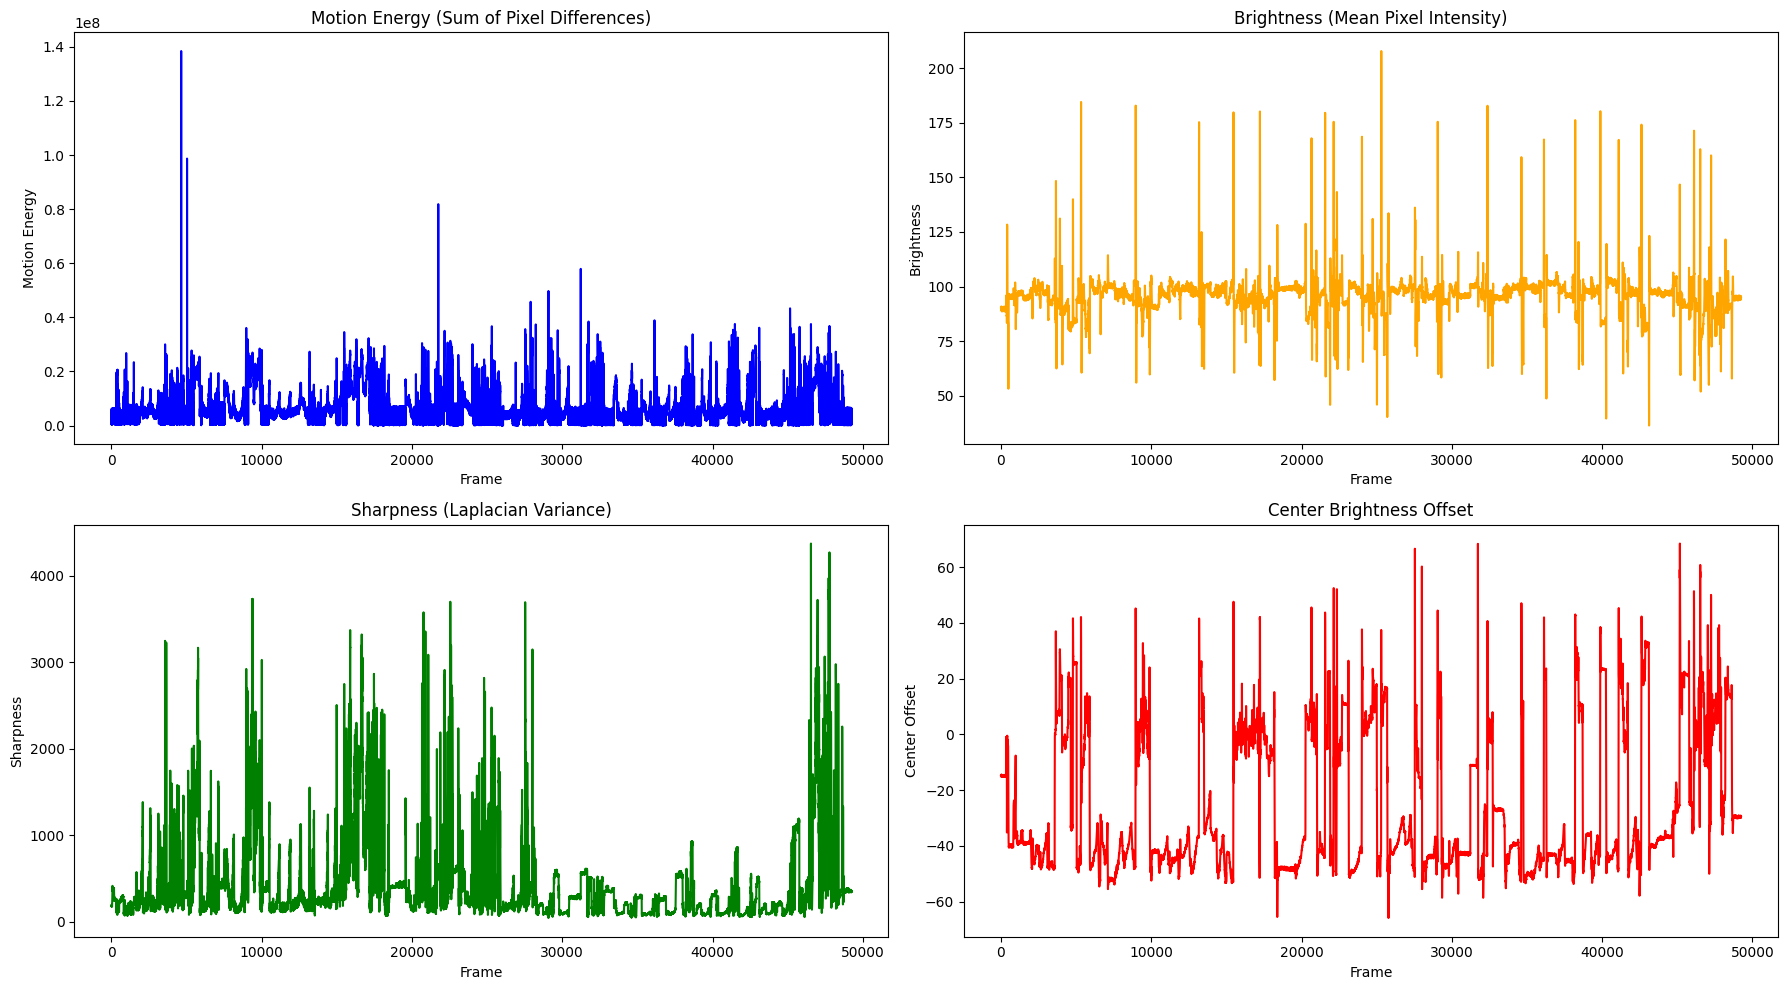

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

video_path = '/content/drive/MyDrive/3D_reconstruction/200S0264.mp4'

cap = cv2.VideoCapture(video_path)

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
if fps == 0:
    fps = 30
duration = frame_count / fps

print(f"Frames: {frame_count}, FPS: {fps:.2f}, Duration: {duration:.2f} sec")

motion_energy = []
brightness = []
sharpness = []
center_offsets = []

ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

frame_idx = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Motion energy (difference between frames)
    diff = cv2.absdiff(prev_gray, gray)
    motion_energy.append(np.sum(diff))

    # Brightness (mean intensity)
    brightness.append(np.mean(gray))

    # Sharpness (variance of Laplacian)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    sharpness.append(laplacian_var)

    # Center brightness (center of pipe detection)
    h, w = gray.shape
    center_crop = gray[h//3:2*h//3, w//3:2*w//3]
    offset = np.mean(center_crop) - np.mean(gray)
    center_offsets.append(offset)

    prev_gray = gray
    frame_idx += 1

cap.release()

print(f"Processed {frame_idx} frames.")

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.plot(motion_energy, color='blue')
plt.title('Motion Energy (Sum of Pixel Differences)')
plt.xlabel('Frame')
plt.ylabel('Motion Energy')

plt.subplot(2,2,2)
plt.plot(brightness, color='orange')
plt.title('Brightness (Mean Pixel Intensity)')
plt.xlabel('Frame')
plt.ylabel('Brightness')

plt.subplot(2,2,3)
plt.plot(sharpness, color='green')
plt.title('Sharpness (Laplacian Variance)')
plt.xlabel('Frame')
plt.ylabel('Sharpness')

plt.subplot(2,2,4)
plt.plot(center_offsets, color='red')
plt.title('Center Brightness Offset')
plt.xlabel('Frame')
plt.ylabel('Center Offset')

plt.tight_layout()
plt.show()


In [ ]:
!apt update -y
!apt install -y colmap

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,701 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/u

In [ ]:
!pip install timm
!git clone https://github.com/intel-isl/MiDaS.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import cv2
import os
import shutil
from pathlib import Path

In [ ]:
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
sample_rate = 10 

In [ ]:
video_path = '/content/drive/MyDrive/3D_reconstruction/200S0264.mp4'
frames_folder = '/content/MyDrive/frames_sampled'
os.makedirs(frames_folder, exist_ok=True)

In [ ]:
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break
    if i % sample_rate == 0:
        filename = os.path.join(frames_folder, f'frame_{i:05d}.jpg')
        cv2.imwrite(filename, frame)

cap.release()
print(f'Done extracting {len(os.listdir(frames_folder))} frames.')

Done extracting 0 frames.


In [ ]:
import cv2
import os

video_path = '/content/drive/MyDrive/3D_reconstruction/200S0264.mp4'
output_folder = '/content/MyDrive/frames_sampled'

os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(video_path)

frame_count = 0
saved_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 10 == 0:
        frame_filename = os.path.join(output_folder, f'frame_{saved_count:05d}.jpg')
        cv2.imwrite(frame_filename, frame)
        saved_count += 1

    frame_count += 1

cap.release()
print(f"Done! Saved {saved_count} frames to {output_folder}")


Done! Saved 4925 frames to /content/MyDrive/frames_sampled


In [ ]:
!mv /content/MyDrive/frames_sampled /content/drive/MyDrive/frames_sampled

#### SIFT feature detection

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob

frames_folder = '/content/drive/MyDrive/frames_sampled'

image_paths = sorted(glob(os.path.join(frames_folder, '*.jpg')))
sift = cv2.SIFT_create()

for idx, image_path in enumerate(image_paths):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    img_keypoints = cv2.drawKeypoints(
        gray, keypoints, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(8, 8))
    plt.imshow(img_keypoints, cmap='gray')
    plt.title(f'Frame {idx+1} - {os.path.basename(image_path)}\nKeypoints detected: {len(keypoints)}')
    plt.axis('off')
    plt.show()

    print(f"[Frame {idx+1}] {os.path.basename(image_path)} - Keypoints: {len(keypoints)}, Descriptor shape: {descriptors.shape if descriptors is not None else 'None'}")

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

image_paths = sorted(glob('/content/drive/MyDrive/frames_sampled/*.jpg'))

img1 = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)  # First image
img2 = cv2.imread(image_paths[1], cv2.IMREAD_GRAYSCALE)  # Second image

sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

matches = sorted(matches, key = lambda x: x.distance)

img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 10))
plt.imshow(img_matches)
plt.title('Feature Matches Between Images')
plt.axis('off')
plt.show()

print(f"Number of matches: {len(matches)}")

IndexError: list index out of range

In [ ]:
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

fundamental_matrix, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

img_inliers = cv2.drawMatches(img1, keypoints1, img2, keypoints2, [matches[i] for i in range(len(matches)) if mask[i]], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 10))
plt.imshow(img_inliers)
plt.title('Inlier Matches After RANSAC')
plt.axis('off')
plt.show()

# Print the fundamental matrix
print("Fundamental Matrix:")
print(fundamental_matrix)

NameError: name 'matches' is not defined

In [ ]:
K = np.eye(3) 

E = K.T @ fundamental_matrix @ K
_, R, T, mask = cv2.recoverPose(E, pts1_inliers, pts2_inliers)

print("Rotation Matrix:")
print(R)
print("Translation Vector:")
print(T)

Rotation Matrix:
[[ 0.97444621  0.02359267 -0.22337852]
 [ 0.02353092  0.97827492  0.20597205]
 [ 0.22338504 -0.20596499  0.95272113]]
Translation Vector:
[[-0.67778952]
 [-0.73525553]
 [-0.0008164 ]]


In [ ]:
print(f"Number of inlier points: {len(pts1_inliers)}")
print(f"pts1_inliers shape: {pts1_inliers.shape}")
print(f"pts2_inliers shape: {pts2_inliers.shape}")


Number of inlier points: 8763
pts1_inliers shape: (8763, 1, 2)
pts2_inliers shape: (8763, 1, 2)


In [ ]:
print(f"Rotation matrix shape: {R.shape}")
print(f"Translation vector shape: {T.shape}")

Rotation matrix shape: (3, 3)
Translation vector shape: (3, 1)


In [ ]:
print(f"pts1_inliers shape: {pts1_inliers.shape}")
print(f"pts2_inliers shape: {pts2_inliers.shape}")

pts1_inliers shape: (8763, 1, 2)
pts2_inliers shape: (8763, 1, 2)


In [ ]:
pts1_inliers = pts1_inliers.reshape(-1, 2)
pts2_inliers = pts2_inliers.reshape(-1, 2)


In [ ]:
pts1_inliers_homogeneous = np.hstack([pts1_inliers, np.ones((pts1_inliers.shape[0], 1))])
pts2_inliers_homogeneous = np.hstack([pts2_inliers, np.ones((pts2_inliers.shape[0], 1))])

pts1_inliers_normalized shape: (8763, 2)
pts2_inliers_normalized shape: (8763, 2)


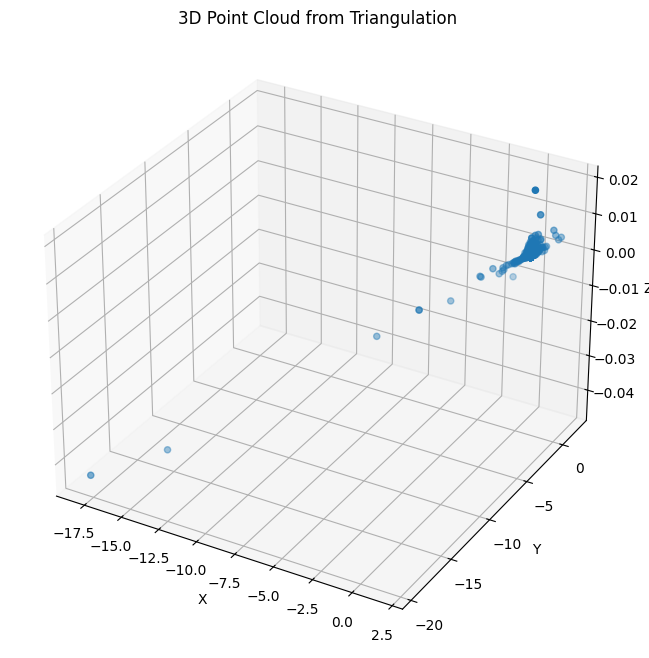

3D Points: [[4.17670195e-01 4.52723608e-01 4.82354864e-04]
 [4.20816429e-01 4.55047902e-01 3.42726236e-04]
 [4.19035279e-01 4.54671882e-01 5.45633158e-04]
 ...
 [4.19560317e-01 4.55662345e-01 6.02085479e-04]
 [4.24275439e-01 4.63478158e-01 9.71795578e-04]
 [4.22546567e-01 4.56631467e-01 3.05434548e-04]]


In [ ]:
pts1_inliers_homogeneous = np.hstack([pts1_inliers, np.ones((pts1_inliers.shape[0], 1))])
pts2_inliers_homogeneous = np.hstack([pts2_inliers, np.ones((pts2_inliers.shape[0], 1))])

pts1_inliers_normalized = pts1_inliers_homogeneous[:, :2] / pts1_inliers_homogeneous[:, 2][:, np.newaxis]
pts2_inliers_normalized = pts2_inliers_homogeneous[:, :2] / pts2_inliers_homogeneous[:, 2][:, np.newaxis]

print(f"pts1_inliers_normalized shape: {pts1_inliers_normalized.shape}")
print(f"pts2_inliers_normalized shape: {pts2_inliers_normalized.shape}")

P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # Camera 1 (identity matrix)
P2 = np.hstack((R, T))  # Camera 2 with rotation and translation

points_3d_homogeneous = cv2.triangulatePoints(P1, P2, pts1_inliers_normalized.T, pts2_inliers_normalized.T)

points_3d = points_3d_homogeneous[:3] / points_3d_homogeneous[3]

points_3d = points_3d.T

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Point Cloud from Triangulation')
plt.show()

print("3D Points:", points_3d)